In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score
from sklearn.naive_bayes import GaussianNB

In [3]:
### !!! VERY CONSUMING OPERATION !!! ###

# Path to the directory containing the CSV files
path = "TON_IOT_Datasets/Processed_Network_dataset/"

# Define the target number of rows
target_row_count = 5_000_000
rows_per_file = target_row_count // 23

# Use glob to get all file paths matching the pattern
all_files = glob.glob(path + "Network_dataset_*.csv")

# Initialize an empty list to store sampled DataFrames
sampled_dfs = []

# Loop through each file, read it in its entirety, and sample rows
for filename in all_files:
    df = pd.read_csv(filename, low_memory=False)
    sampled_df = df.sample(n=min(len(df), rows_per_file), random_state=42)
    sampled_dfs.append(sampled_df)

# Concatenate all sampled DataFrames into one
combined_df = pd.concat(sampled_dfs, ignore_index=True)

# Adjust the sample size if combined_df has fewer rows than target_row_count
final_sample_size = min(len(combined_df), target_row_count)

# Randomly shuffle and limit rows to final_sample_size
final_df = combined_df.sample(n=final_sample_size, random_state=42).reset_index(drop=True)
df = final_df

df.head()

ts        src_ip  src_port          dst_ip  dst_port proto service  \
0  1556029027  192.168.1.31     53386  192.168.35.151       443   tcp       -   
1  1556027221  192.168.1.30     53241   192.168.1.180     63606   tcp       -   
2  1556238678  192.168.1.30     48844   192.168.1.184        80   tcp    http   
3  1556263694  192.168.1.38     41894   192.168.1.152        80   tcp       -   
4  1556133212  192.168.1.30       438   192.168.1.184       438   tcp       -   

    duration src_bytes  dst_bytes  ... http_status_code  http_user_agent  \
0   0.000000         0          0  ...                0                -   
1   0.000000         0          0  ...                0                -   
2   0.006884       175        171  ...                0                -   
3  39.893225         0          0  ...                0                -   
4   0.000001         0          0  ...                0                -   

   http_orig_mime_types  http_resp_mime_types  weird_name  weird_addl  \
0                     -                     -           -           -   
1                     -                     -           -           -   
2                     -                     -           -           -   
3                     -                     -           -           -   
4                     -                     -           -           -   

  weird_notice  label      type  uid  
0            -      1  scanning  NaN  
1            -      1  scanning  NaN  
2            -      1      ddos  NaN  
3            -      1      ddos  NaN  
4            -      1       dos  NaN  

[5 rows x 47 columns]

In [37]:
# Display the distribution of attack types in the final dataset
df['type'].value_counts()

type
scanning      1552228
ddos          1340172
dos            733790
xss            458530
password       373434
backdoor       239504
normal         187326
injection       98449
ransomware      15887
mitm              673
Name: count, dtype: int64

In [38]:
# Check for null values in the features
df.isnull().sum()

ts                              0
src_ip                          0
src_port                        0
dst_ip                          0
dst_port                        0
proto                           0
service                         0
duration                        0
src_bytes                       0
dst_bytes                       0
conn_state                      0
missed_bytes                    0
src_pkts                        0
src_ip_bytes                    0
dst_pkts                        0
dst_ip_bytes                    0
dns_query                       0
dns_qclass                      0
dns_qtype                       0
dns_rcode                       0
dns_AA                          0
dns_RD                          0
dns_RA                          0
dns_rejected                    0
ssl_version                     0
ssl_cipher                      0
ssl_resumed                     0
ssl_established                 0
ssl_subject                     0
ssl_issuer    

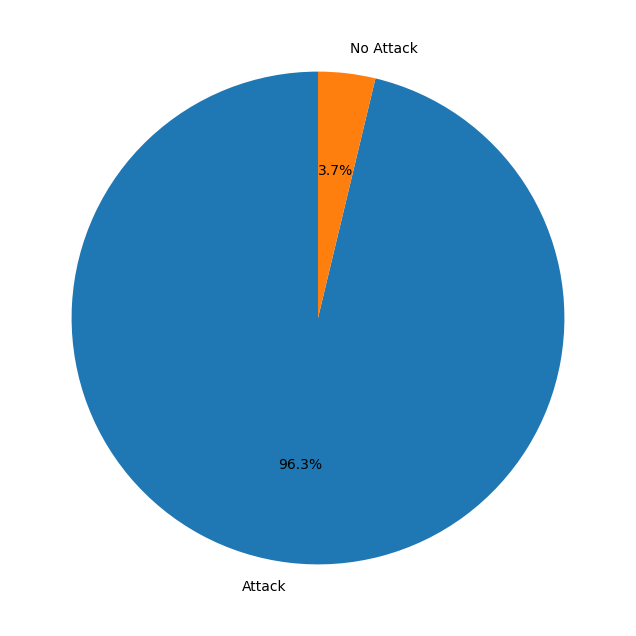

In [5]:
# Create pie chart which shows the percentage of attacks
attack_counts = df['label'].value_counts()
attack_counts.plot(kind='pie', 
                   labels=attack_counts.index.map({0: 'No Attack', 1: 'Attack'}), 
                   autopct='%1.1f%%', 
                   startangle=90, 
                   figsize=(8, 8))

# Show the plot
plt.ylabel('')  # Remove the y-axis label
plt.show()

In [40]:
# Show the types of each column
df.dtypes

ts                          int64
src_ip                     object
src_port                    int64
dst_ip                     object
dst_port                    int64
proto                      object
service                    object
duration                  float64
src_bytes                  object
dst_bytes                   int64
conn_state                 object
missed_bytes                int64
src_pkts                    int64
src_ip_bytes                int64
dst_pkts                    int64
dst_ip_bytes                int64
dns_query                  object
dns_qclass                  int64
dns_qtype                   int64
dns_rcode                   int64
dns_AA                     object
dns_RD                     object
dns_RA                     object
dns_rejected               object
ssl_version                object
ssl_cipher                 object
ssl_resumed                object
ssl_established            object
ssl_subject                object
ssl_issuer    

In [5]:
label_encoder = LabelEncoder()
label_mappings = {}

# Apply label encoding to each non-numeric column and store mappings
for column in df.select_dtypes(include=['object']).columns:
    # Convert the column to string type to avoid mixed types
    df[column] = df[column].astype(str)
    
    df.loc[:, column] = label_encoder.fit_transform(df[column])

    # Convert the encoded column to integer type explicitly
    df[column] = df[column].astype(int)
    
    # Store the mapping of label to encoded value for the column
    label_mappings[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

for column, mapping in label_mappings.items():
    print(f"{column}: {dict(list(mapping.items())[:5])}")

src_ip: {'0': 0, '0.0.0.0': 1, '0.105.134.68': 2, '0.11.129.89': 3, '0.130.71.43': 4}
dst_ip: {'101.119.11.10': 0, '101.119.11.11': 1, '101.119.11.16': 2, '101.119.11.17': 3, '101.119.11.19': 4}
proto: {'icmp': 0, 'tcp': 1, 'udp': 2}
service: {'-': 0, 'dce_rpc': 1, 'dce_rpc;gssapi;smb;ntlm': 2, 'dce_rpc;ntlm': 3, 'dhcp': 4}
src_bytes: {'0': 0, '0.0.0.0': 1, '1': 2, '10': 3, '100': 4}
conn_state: {'OTH': 0, 'REJ': 1, 'RSTO': 2, 'RSTOS0': 3, 'RSTR': 4}
dns_query: {'(empty)': 0, '*\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00': 1, '-': 2, '../nessus': 3, '0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.ip6.arpa': 4}
dns_AA: {'-': 0, 'F': 1, 'T': 2}
dns_RD: {'-': 0, 'F': 1, 'T': 2}
dns_RA: {'-': 0, 'F': 1, 'T': 2}
dns_rejected: {'-': 0, 'F': 1, 'T': 2}
ssl_version: {'-': 0, 'TLSv10': 1, 'TLSv11': 2, 'TLSv12': 3, 'TLSv13': 4}
ssl_cipher: {'-': 0, 'TLS_AES_128_GCM_SHA256': 1, 'TLS_DHE_RSA_WITH_AES_128_CBC_SHA': 2, 'TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA25

In [42]:
# Print the mapping specifically for the 'type' column
print("Type column mappings:", label_mappings.get('type', 'No mapping found for type'))

Type column mappings: {'backdoor': 0, 'ddos': 1, 'dos': 2, 'injection': 3, 'mitm': 4, 'normal': 5, 'password': 6, 'ransomware': 7, 'scanning': 8, 'xss': 9}


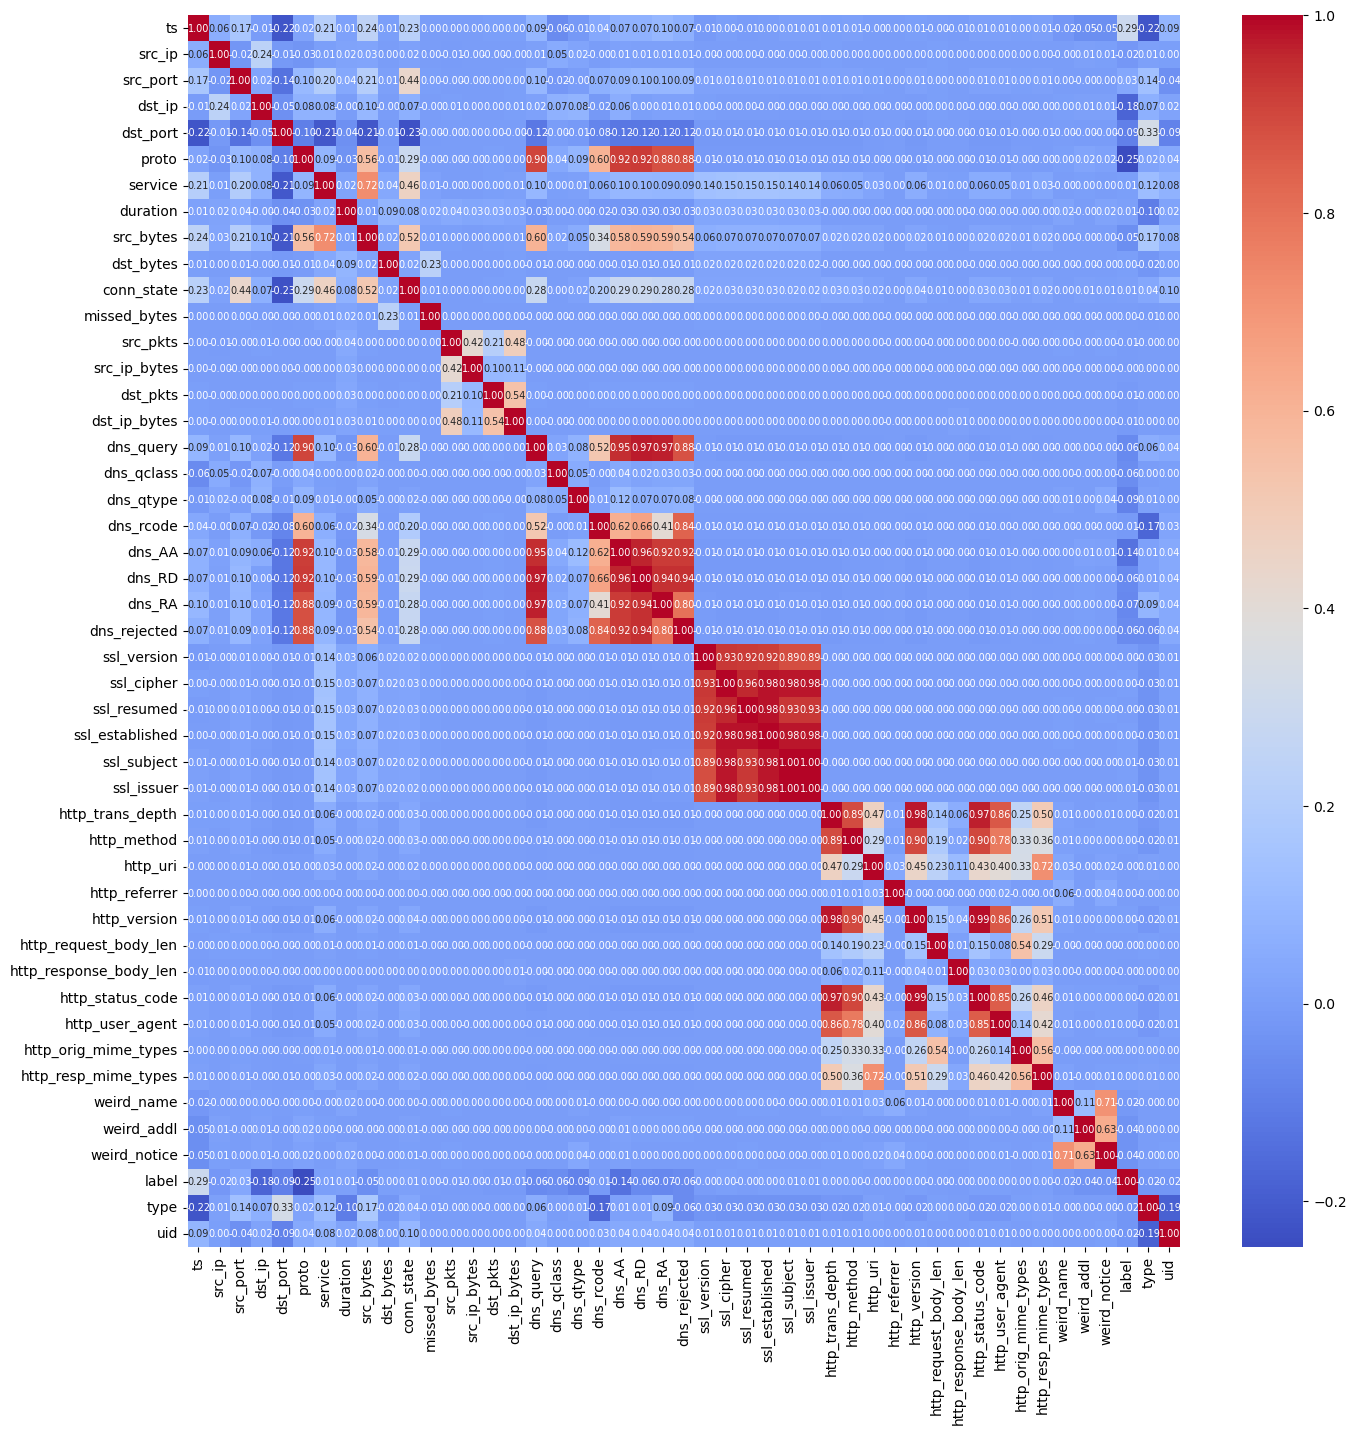

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove columns with only one unique value and create a copy
df = df.loc[:, df.nunique() > 1].copy()

# Calculate the correlation matrix
corr = df.corr()

# Visualize the correlation matrix with improved readability
plt.figure(figsize=(16, 16))  # Set a large figure size
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 7})

# Show the plot
plt.show()

In [9]:
# Identify and drop highly correlated features
# Set a threshold for correlation
threshold = 0.80
to_drop = set()

for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > threshold:
            colname = corr.columns[i]
            to_drop.add(colname)

# Drop the correlated features
df = df.drop(columns=to_drop)

df.head()

ts  src_ip  src_port  dst_ip  dst_port  proto  service   duration  \
0  1556029027    2084     53386    1197       443      1        0   0.000000   
1  1556027221    2083     53241    1122     63606      1        0   0.000000   
2  1556238678    2083     48844    1123        80      1       13   0.006884   
3  1556263694    2091     41894    1120        80      1        0  39.893225   
4  1556133212    2083       438    1123       438      1        0   0.000001   

   src_bytes  dst_bytes  ...  http_request_body_len  http_response_body_len  \
0          0          0  ...                      0                       0   
1          0          0  ...                      0                       0   
2       3829        171  ...                      0                       0   
3          0          0  ...                      0                       0   
4          0          0  ...                      0                       0   

   http_orig_mime_types  http_resp_mime_types  weird_name  weird_addl  \
0                     0                     0           0           0   
1                     0                     0           0           0   
2                     0                     0           0           0   
3                     0                     0           0           0   
4                     0                     0           0           0   

   weird_notice  label  type     uid  
0             0      1     8  217388  
1             0      1     8  217388  
2             0      1     1  217388  
3             0      1     1  217388  
4             0      1     2  217388  

[5 rows x 33 columns]

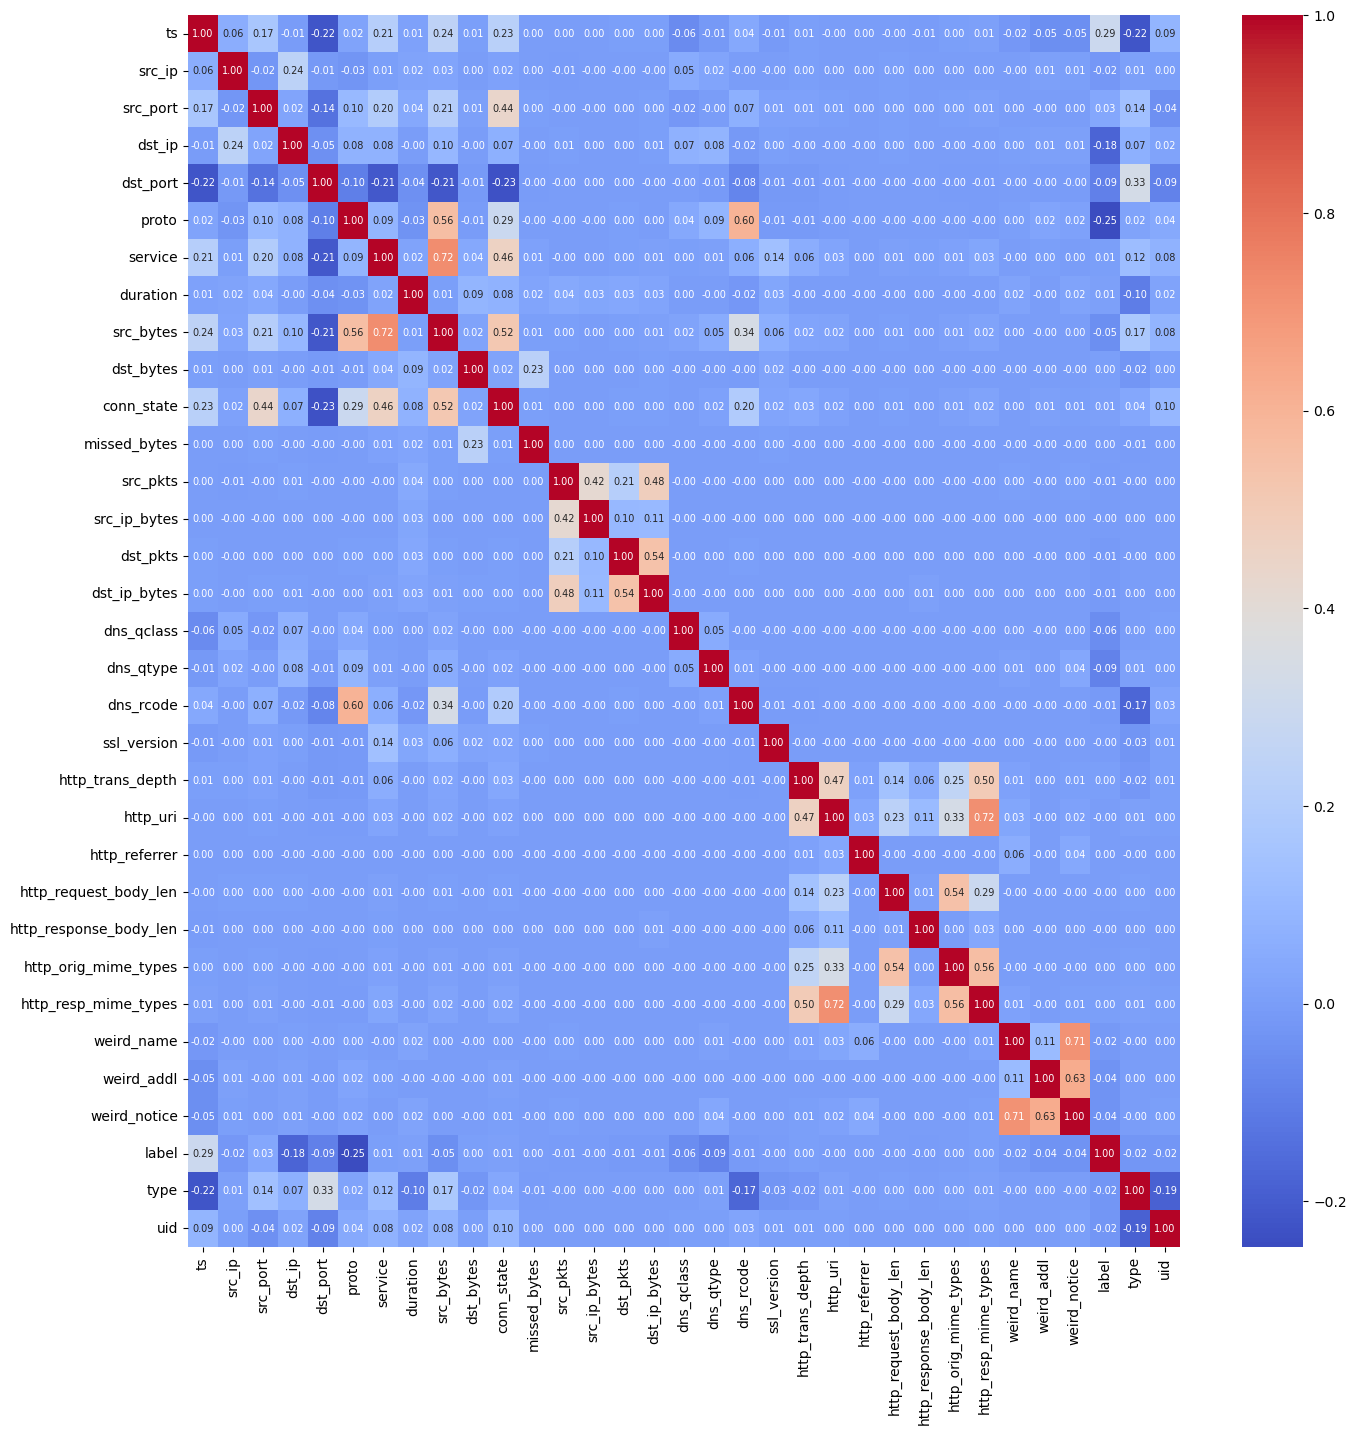

In [13]:
# Calculate correlation matrix again after the reduction
corr = df.corr()

# Visualize the correlation matrix with improved readability
plt.figure(figsize=(16, 16))  # Set a large figure size
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 7})

# Show the plot
plt.show()

In [11]:
# Remove the attack type column
features = df.drop(['type', 'label'], axis=1)  

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform PCA without specifying n_components
pca = PCA()
pca.fit(scaled_features)

# Calculate cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

print(f'Explained variance by each component: {pca.explained_variance_ratio_}')

# Set the variance threshold 
threshold = 0.90
n_components = np.argmax(explained_variance >= threshold) + 1

print(f"Number of components to retain {threshold*100}% variance: {n_components}")

# Perform PCA again with the chosen number of components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, 
                      columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['type'] = df['type'].values
pca_df['label'] = df['label'].values

Explained variance by each component: [0.09527186 0.08577852 0.06493574 0.06353201 0.04758818 0.04174183
 0.04012568 0.03615119 0.03488282 0.03458212 0.03408034 0.03253943
 0.0321506  0.03178747 0.03105691 0.03077693 0.02870316 0.02820009
 0.02726556 0.02581869 0.0245788  0.02261861 0.02010001 0.01859417
 0.01479001 0.01428982 0.01330012 0.01065463 0.00681192 0.00385409
 0.0034387 ]
Number of components to retain 90.0% variance: 23


In [13]:
df = pca_df;
df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.410050  0.055690  0.016365 -0.007907 -0.191401 -0.012621 -0.075048   
1 -1.454878  0.273129  0.042412 -0.003111  0.781393 -0.168427  0.234892   
2  1.540593 -0.310775 -0.074375 -0.006319 -1.158003 -0.178954 -0.285642   
3  0.014022 -0.032868 -0.049147  0.031180 -0.612528 -0.149166 -0.081367   
4 -1.588095  0.296398 -0.003116  0.004982  0.480007  0.263751  0.098007   

        PC8       PC9      PC10  ...      PC16      PC17      PC18      PC19  \
0  0.045918  0.013115 -0.068783  ... -0.106955  0.177996  0.244379 -0.860253   
1 -0.196650 -0.056244  1.355222  ... -0.029938  1.796380 -1.969589 -1.070314   
2 -0.005575 -0.033386  0.339717  ... -0.223763  0.311187 -0.275141  0.231494   
3  0.137192  0.056857 -0.506626  ...  0.010662 -0.104819  0.294307 -0.390774   
4 -0.015724  0.007718 -0.553379  ...  0.075836 -0.520442  0.337305  0.955294   

       PC20      PC21      PC22      PC23  type  label  
0 -0.541419 -0.113575  0.478835 -0.001186     8      1  
1  2.031113 -0.010738 -0.763628 -0.021771     8      1  
2 -0.085343  0.056561  0.459521 -0.002472     1      1  
3  0.060583  0.030866  0.063049 -0.005617     1      1  
4 -0.449285  0.079153  0.061786  0.008016     2      1  

[5 rows x 25 columns]

In [15]:
# Bogdan analysis
df = df.dropna()

# Filter the DataFrame to include only rows where 'type' column is 0 (backdoor) or 5 (normal)
filtered_df = df[(df['type'] == 0) | (df['type'] == 5)]

X_df = filtered_df.drop(columns=['label', 'type'])
Y_df = filtered_df['label']

X_df.head()
#Y_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
19 -0.502608  0.062535 -0.153020  0.011977 -0.668706 -0.297744 -0.309201   
27 -0.498873  0.061739 -0.153412  0.011985 -0.672474 -0.299566 -0.310491   
43 -3.121830  0.645001  0.615028 -0.057139  2.834102  0.394989  1.085550   
67  2.727230 -0.685025  0.162671 -0.092043  1.531827  0.358798  0.188831   
76 -2.117461  0.399837 -0.078102  0.017472  0.773331  0.223479  0.153168   

         PC8       PC9      PC10  ...      PC14      PC15      PC16      PC17  \
19  0.186065 -0.007022 -0.676374  ...  0.223048  0.107356  0.122890 -0.555167   
27  0.186721 -0.007045 -0.676752  ...  0.223602  0.107667  0.122865 -0.555392   
43 -0.628294 -0.004130  2.902330  ... -0.767065 -0.309295 -0.663027  2.732397   
67 -0.035591  0.024192  0.269767  ... -0.070144  0.000156 -0.013591  0.599141   
76 -0.095644 -0.049369  0.122319  ...  0.058926 -0.015281  0.263108  0.350306   

        PC18      PC19      PC20      PC21      PC22      PC23  
19  0.413799 -0.695499  0.840552 -0.169706 -1.011835  0.013534  
27  0.414756 -0.701240  0.843227 -0.170564 -1.013755  0.013542  
43 -0.958943 -1.233963 -4.000155  0.035178  4.809234 -0.046792  
67 -0.165792 -0.639819 -0.950568 -0.073285  0.060760  0.016713  
76 -1.233340  0.703279  2.196165  0.103903 -1.751326  0.001688  

[5 rows x 23 columns]

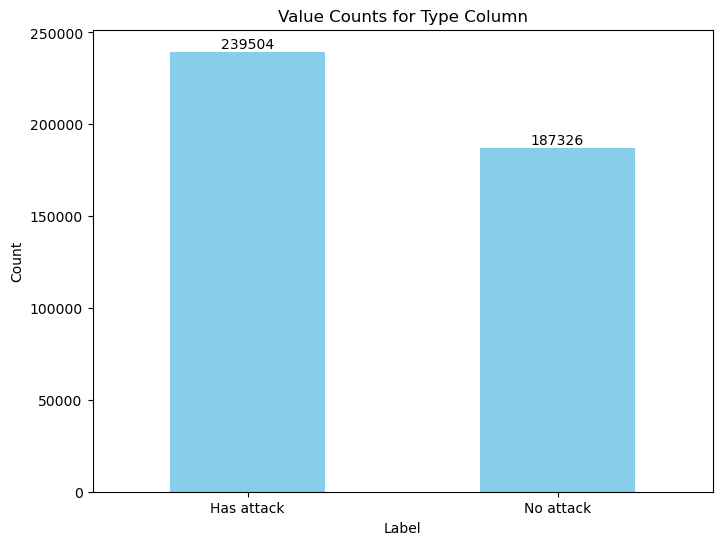

In [17]:
# Get the value counts for the 'label' column
type_counts = Y_df.value_counts()

# Plot a bar chart
plt.figure(figsize=(8, 6))
ax = type_counts.plot(kind='bar', color='skyblue')
plt.title('Value Counts for Type Column')
plt.xlabel('Label')
plt.ylabel('Count')

# Set custom labels
ax.set_xticklabels(['Has attack', 'No attack'], rotation=0)

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

plt.show()

In [23]:
filtered_df.dtypes

PC1      float64
PC2      float64
PC3      float64
PC4      float64
PC5      float64
PC6      float64
PC7      float64
PC8      float64
PC9      float64
PC10     float64
PC11     float64
PC12     float64
PC13     float64
PC14     float64
PC15     float64
PC16     float64
PC17     float64
PC18     float64
PC19     float64
PC20     float64
PC21     float64
PC22     float64
PC23     float64
type       int64
label      int64
dtype: object

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Initialize models
rf = RandomForestClassifier(random_state=39, 
                            class_weight='balanced', 
                            n_estimators=5, 
                            max_depth=3, 
                            max_features='log2', 
                            min_samples_split=40,
                            min_samples_leaf=20,
                            max_leaf_nodes=2,
                            bootstrap=True,
                            max_samples=0.5)

lgbm = LGBMClassifier(random_state=39,
                        n_estimators=30,
                        learning_rate=0.01,
                        max_depth=4,
                        num_leaves=2,
                        min_data_in_leaf=50,
                        feature_fraction=0.8,
                        bagging_fraction=0.8,
                        bagging_freq=5,
                        lambda_l1=1.0,
                        lambda_l2=1.0,
                         verbose=-1)

In [27]:
from sklearn.model_selection import StratifiedKFold

# Define a function to calculate all metrics
def calculate_metrics(y_true, y_pred):
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate

    return {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity (Recall)': recall,
        'Specificity': specificity
    }

# Cross-validation setup for Random Forest
kf = StratifiedKFold(n_splits=5)
rf_metrics = []

print("Random Forest Cross-Validation Results:")
for fold, (train_index, test_index) in enumerate(kf.split(X_df, Y_df), start=1):
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = Y_df.iloc[train_index], Y_df.iloc[test_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    metrics['Fold'] = fold  # Add fold number
    rf_metrics.append(metrics)

# Display results for Random Forest
rf_results_df = pd.DataFrame(rf_metrics)
print(rf_results_df)
print("Mean Results for Random Forest:")
print(rf_results_df.mean(numeric_only=True))

Random Forest Cross-Validation Results:
      TP     TN    FP   FN  Accuracy  Precision  Sensitivity (Recall)  \
0  47490  33573  3892  411  0.949594   0.924254              0.991420   
1  47541  33558  3907  360  0.950015   0.924059              0.992484   
2  47523  33408  4057  378  0.948047   0.921345              0.992109   
3  47552  33556  3909  349  0.950121   0.924040              0.992714   
4  47474  33660  3806  426  0.950425   0.925780              0.991106   

   Specificity  Fold  
0     0.896116     1  
1     0.895716     2  
2     0.891712     3  
3     0.895663     4  
4     0.898415     5  
Mean Results for Random Forest:
TP                      47516.000000
TN                      33551.000000
FP                       3914.200000
FN                        384.800000
Accuracy                    0.949640
Precision                   0.923896
Sensitivity (Recall)        0.991967
Specificity                 0.895524
Fold                        3.000000
dtype: float64


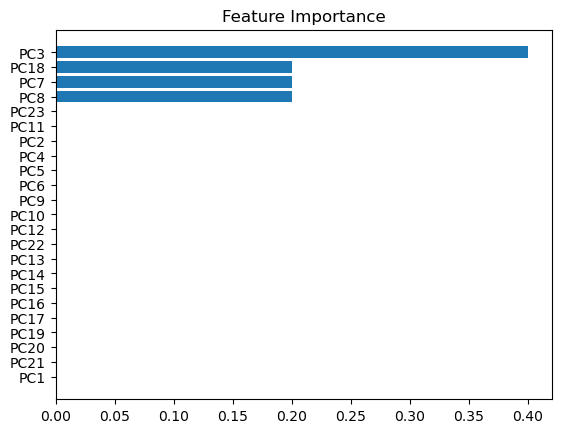

In [29]:
feature_importances = rf.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_df.columns[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [79]:
# Cross-validation setup for LGBM
kf = StratifiedKFold(n_splits=5)
lgbm_metrics = []

print("\nLGBM Cross-Validation Results:")
for fold, (train_index, test_index) in enumerate(kf.split(X_df, Y_df), start=1):
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = Y_df.iloc[train_index], Y_df.iloc[test_index]
    
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    metrics['Fold'] = fold  # Add fold number
    lgbm_metrics.append(metrics)

# Display results for lgbm
lgbm_results_df = pd.DataFrame(lgbm_metrics)
print(lgbm_results_df)
print("Mean Results for LGBM:")
print(lgbm_results_df.mean(numeric_only=True))


LGBM Cross-Validation Results:
      TP     TN    FP   FN  Accuracy  Precision  Sensitivity (Recall)  \
0  47430  31282  6183  471  0.922053   0.884673              0.990167   
1  47505  31261  6204  396  0.922686   0.884489              0.991733   
2  47458  31370  6095  443  0.923412   0.886188              0.990752   
3  47598  31343  6122  303  0.924736   0.886039              0.993674   
4  47526  31468  5998  374  0.925357   0.887938              0.992192   

   Specificity  Fold  
0     0.834966     1  
1     0.834405     2  
2     0.837315     3  
3     0.836594     4  
4     0.839908     5  
Mean Results for LGBM:
TP                      47503.400000
TN                      31344.800000
FP                       6120.400000
FN                        397.400000
Accuracy                    0.923649
Precision                   0.885865
Sensitivity (Recall)        0.991704
Specificity                 0.836638
Fold                        3.000000
dtype: float64


In [53]:
# TOSHKO
df = df.dropna()

filtered_df = df[(df['type'] == 3) | (df['type'] == 5)]

# Prepare features (X) and target (y)
X = filtered_df.drop(columns=['label', 'type'])  # Drop non-feature columns
y = filtered_df['label']  # Target variable is 'label'

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize StratifiedKFold with 5 splits
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

# Initialize lists to store metrics
precision_list = []
accuracy_list = []
sensitivity_list = []
tp_list, tn_list, fp_list, fn_list = [], [], [], []

# Perform cross-validation
for run_index, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y), start=1):  # Use enumerate to track the run index
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Initialize and train Logistic Regression model
    model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=50)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Append confusion matrix components
    tp_list.append(tp)
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)  # Sensitivity = Recall
    
    # Append metrics to lists
    precision_list.append(precision)
    accuracy_list.append(accuracy)
    sensitivity_list.append(sensitivity)
    
    # Print results for the current run
    print(f"=== RUN NUMBER {run_index} ===")  # Display the current run index
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"Precision: {precision:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Sensitivity (Recall): {sensitivity:.2f}")
    print()


# Calculate average metrics
avg_precision = sum(precision_list) / len(precision_list)
avg_accuracy = sum(accuracy_list) / len(accuracy_list)
avg_sensitivity = sum(sensitivity_list) / len(sensitivity_list)
avg_tp = sum(tp_list) / len(tp_list)
avg_tn = sum(tn_list) / len(tn_list)
avg_fp = sum(fp_list) / len(fp_list)
avg_fn = sum(fn_list) / len(fn_list)

print("=== Cross-Validation Results (5-Fold) ===")
print(f"Average True Positives (TP): {avg_tp:.2f}")
print(f"Average True Negatives (TN): {avg_tn:.2f}")
print(f"Average False Positives (FP): {avg_fp:.2f}")
print(f"Average False Negatives (FN): {avg_fn:.2f}")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Accuracy: {avg_accuracy:.2f}")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.2f}")

=== RUN NUMBER 1 ===
True Positives (TP): 18476
True Negatives (TN): 36524
False Positives (FP): 941
False Negatives (FN): 1214
Precision: 0.95
Accuracy: 0.96
Sensitivity (Recall): 0.94

=== RUN NUMBER 2 ===
True Positives (TP): 18429
True Negatives (TN): 36614
False Positives (FP): 851
False Negatives (FN): 1261
Precision: 0.96
Accuracy: 0.96
Sensitivity (Recall): 0.94

=== RUN NUMBER 3 ===
True Positives (TP): 18401
True Negatives (TN): 36597
False Positives (FP): 868
False Negatives (FN): 1289
Precision: 0.95
Accuracy: 0.96
Sensitivity (Recall): 0.93

=== RUN NUMBER 4 ===
True Positives (TP): 18486
True Negatives (TN): 36553
False Positives (FP): 912
False Negatives (FN): 1204
Precision: 0.95
Accuracy: 0.96
Sensitivity (Recall): 0.94

=== RUN NUMBER 5 ===
True Positives (TP): 18483
True Negatives (TN): 36588
False Positives (FP): 878
False Negatives (FN): 1206
Precision: 0.95
Accuracy: 0.96
Sensitivity (Recall): 0.94

=== Cross-Validation Results (5-Fold) ===
Average True Positives 

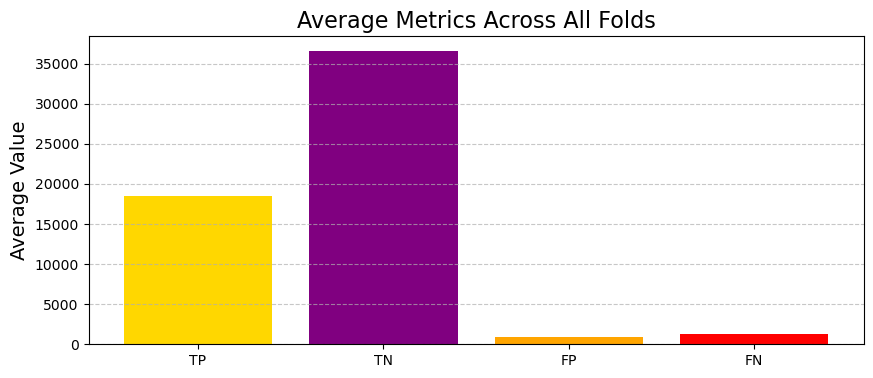

In [50]:

# Number of folds
folds = np.arange(1, 6)  # For 5 folds

# Create a dictionary of results for easier visualization
results = {
    "TP": tp_list,
    "TN": tn_list,
    "FP": fp_list,
    "FN": fn_list,
}

# Bar plot for average metrics
avg_metrics = [avg_tp, avg_tn, avg_fp, avg_fn]
metric_names = ["TP", "TN", "FP", "FN"]

plt.figure(figsize=(10, 4))
plt.bar(metric_names, avg_metrics, color=['gold', 'purple', 'orange', 'red'])
plt.title("Average Metrics Across All Folds", fontsize=16)
plt.ylabel("Average Value", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [54]:
from sklearn.tree import DecisionTreeClassifier

df = df.dropna()

filtered_df = df[(df['type'] == 3) | (df['type'] == 5)]

# Prepare features (X) and target (y)
X = filtered_df.drop(columns=['label', 'type'])  # Drop non-feature columns
y = filtered_df['label']  # Target variable is 'label'

model = DecisionTreeClassifier(random_state=50)

# Initialize Stratified K-Fold cross-validator
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

# Initialize lists to store metrics
tp_list, tn_list, fp_list, fn_list = [], [], [], []
precision_list, accuracy_list, sensitivity_list = [], [], []

# Perform cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    print(f"=== Fold {fold} ===")
    
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train the Decision Tree model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Compute confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Compute metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)  # Sensitivity is Recall
    
    # Store metrics for this fold
    tp_list.append(tp)
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)
    precision_list.append(precision)
    accuracy_list.append(accuracy)
    sensitivity_list.append(sensitivity)
    
    # Print results for this fold
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"Precision: {precision:.5f}")
    print(f"Accuracy: {accuracy:.5f}")
    print(f"Sensitivity (Recall): {sensitivity:.5f}")
    print()


avg_tp = sum(tp_list) / len(tp_list)
avg_tn = sum(tn_list) / len(tn_list)
avg_fp = sum(fp_list) / len(fp_list)
avg_fn = sum(fn_list) / len(fn_list)

print("=== Cross-Validation Results (5-Fold) ===")
print(f"Average True Positives (TP): {avg_tp:.2f}")
print(f"Average True Negatives (TN): {avg_tn:.2f}")
print(f"Average False Positives (FP): {avg_fp:.2f}")
print(f"Average False Negatives (FN): {avg_fn:.2f}")
print(f"Average Precision: {np.mean(precision_list):.5f}")
print(f"Average Accuracy: {np.mean(accuracy_list):.5f}")
print(f"Average Sensitivity (Recall): {np.mean(sensitivity_list):.5f}")

=== Fold 1 ===
True Positives (TP): 19670
True Negatives (TN): 37434
False Positives (FP): 31
False Negatives (FN): 20
Precision: 0.99843
Accuracy: 0.99911
Sensitivity (Recall): 0.99898

=== Fold 2 ===
True Positives (TP): 19669
True Negatives (TN): 37432
False Positives (FP): 33
False Negatives (FN): 21
Precision: 0.99833
Accuracy: 0.99906
Sensitivity (Recall): 0.99893

=== Fold 3 ===
True Positives (TP): 19655
True Negatives (TN): 37438
False Positives (FP): 27
False Negatives (FN): 35
Precision: 0.99863
Accuracy: 0.99892
Sensitivity (Recall): 0.99822

=== Fold 4 ===
True Positives (TP): 19664
True Negatives (TN): 37438
False Positives (FP): 27
False Negatives (FN): 26
Precision: 0.99863
Accuracy: 0.99907
Sensitivity (Recall): 0.99868

=== Fold 5 ===
True Positives (TP): 19662
True Negatives (TN): 37431
False Positives (FP): 35
False Negatives (FN): 27
Precision: 0.99822
Accuracy: 0.99892
Sensitivity (Recall): 0.99863

=== Cross-Validation Results (5-Fold) ===
Average True Positives 